# Initial Setup

Mentions: 
- Thank you for emasters for their excellent [tutorial](https://www.youtube.com/watch?v=DLngCtsG3bk)

In [46]:
# Check for Nvidia GPU
!nvidia-smi

Thu Nov 25 05:42:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    60W / 149W |     59MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
#imports
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import math
import decimal
import copy

# Data Prep

### Clone Darknet + Config

In [49]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15368, done.
remote: Total 15368 (delta 0), reused 0 (delta 0), pack-reused 15368
Receiving objects: 100% (15368/15368), 13.98 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (10335/10335), done.


In [50]:
#Configure Darknet to enable cv, gpu and cudann
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [51]:
#Compile Darknet
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [52]:
#Configure yolov3.cfg
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg #Copy two files

!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 8000/' cfg/yolov3_training.cfg

#2configure two classes
!sed -i '610 s@classes=80@classes=4@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=4@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=4@' cfg/yolov3_training.cfg

#1 class at 18 filters while 2 classes at 21
!sed -i '603 s@filters=255@filters=27@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=27@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=27@' cfg/yolov3_training.cfg

In [53]:
!echo -e 'Mask\nNoMask\nUser\nUserTop' > data/obj.names #.names save to obj.names

In [54]:
#.data = 5 lines:
# number of classes | classes= 2\n
# path to train.txt | train = data/train.txt\n
# path to test.txt | valid  = data/test.txt\n
# path to obj.names | names = data/obj.names\n
# path to save trained weights = backup = /content/drive/MyDrive/yolov3'
!echo -e 'classes= 4\ntrain = data/train.txt\nvalid = data/test.txt\nnames = data/obj.names\nbackup = /content/drive/MyDrive/yolov3' > data/obj.data

### Parse Video & Create Labels For Video Input
- Run face detection on first frame: Determines the labels for the rest of the images
- Split the above image to get only the top half of the boundary box. Make this a separate model to train on. 


In [55]:
CascadeFilePath = "/content/drive/MyDrive/Colab Notebooks/Senior Project/opencv-files/lbpcascade_frontalface.xml"

#This is to detect IF there is a face in a picture and extract said face
def getFaceCoordinates(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert image to black/white/gray images (openCV only accepts monochrome images)
    faceCascade = cv2.CascadeClassifier(CascadeFilePath) #this is lpb, load face detector
    
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5) #returns a list of faces in case there's more than 1 face in pic

    if(len(faces) == 0): #if faces list is empty, there are no images
        return None

    #(x, y, w, h) = faces[0] #Assume that there is one face, extract the face x, y, width, height

    
    return faces[0]

In [56]:
#expand it by 10% on each side
def expandLabelArea(box):
  x, y = (box[0], box[1])
  w, h = (box[2], box[3])

  box[0] = int(x - w*.10)
  box[1] = int(y - h*.10)
  box[2] = int(w + w*.20)
  box[3] = int(h + h*.20)

  return box

In [57]:
#Get the top half for second label
def topHalfLabelCVCoor(boxFull):
  box = copy.deepcopy(boxFull)
  box[3] = box[3]/2
  return box

In [58]:
#Convert Bounding Box to YOLO. Taken and modified from: https://github.com/tzutalin/labelImg/blob/master/libs/yolo_io.py
def CVBoxToYOLO(box,img_size):
  xMin, yMin = (box[0], box[1])
  w, h = (box[2], box[3])

  #calculate x & y Max
  xMax = xMin+w
  yMax = yMin+h

  x_center = float((xMin + xMax)) / 2 / img_size[1]
  y_center = float((yMin + yMax)) / 2 / img_size[0]

  w = float((xMax - xMin)) / img_size[1]
  h = float((yMax - yMin)) / img_size[0]

  return x_center, y_center, w, h

In [59]:
#Generate Yolo coordinates as string
def YOLOCoorGen(label: int, imageCVCoor, imageShape):
  YOLOCoor = CVBoxToYOLO(imageCVCoor, imageShape) #convert to YOLO format. Returns a tuple
  YOLOString = []
  for item in YOLOCoor: #each of the four items 
    targetVal = round(item, 6)

    digits = decimal.Decimal(targetVal)
    digits = digits.as_tuple().exponent #get number of digits
    if abs(digits) < 6:
      #start padding with 0
      addingVal = ""
      for iter in range(6 - abs(digits)):
        addingVal = str(targetVal) + "0"
      
      #add to YOLOString once all padded
      YOLOString.append(addingVal)
    else:
      YOLOString.append(str(targetVal))

  return f'{label} {YOLOString[0]} {YOLOString[1]} {YOLOString[2]} {YOLOString[3]}'

In [64]:
#write label for face recognition
def writeLabel(labelName: str, labelInfo, labelInfoHalf):
  label = open(labelName, 'w')
  label.write(labelInfo)
  label.write("\n")
  label.write(labelInfoHalf)
  label.close()

In [60]:
#Extract frames form video
#https://www.geeksforgeeks.org/extract-images-from-video-in-python/
cam = cv2.VideoCapture("/content/drive/MyDrive/yolov3/headVid.mp4")
try:
  if not os.path.exists('data/obj'):
    os.makedirs('data/obj')
except OSError:
  print("Error when creating directory, already exists?")

In [61]:
#Parse video to frames
currentFrame = 0
frameFileNames = []
while(True):
  ret, frame = cam.read()
  if ret:
    #parsing the frames
    name = "./data/obj/frame" + str(currentFrame) + ".jpg"
    frameFileNames.append(str(currentFrame))
    print('Creating...' + name)
    cv2.imwrite(name, frame)
    currentFrame += 1
  else:
    break
cam.release()
cv2.destroyAllWindows()

Creating..../data/obj/frame0.jpg
Creating..../data/obj/frame1.jpg
Creating..../data/obj/frame2.jpg
Creating..../data/obj/frame3.jpg
Creating..../data/obj/frame4.jpg
Creating..../data/obj/frame5.jpg
Creating..../data/obj/frame6.jpg
Creating..../data/obj/frame7.jpg
Creating..../data/obj/frame8.jpg
Creating..../data/obj/frame9.jpg
Creating..../data/obj/frame10.jpg
Creating..../data/obj/frame11.jpg
Creating..../data/obj/frame12.jpg
Creating..../data/obj/frame13.jpg
Creating..../data/obj/frame14.jpg
Creating..../data/obj/frame15.jpg
Creating..../data/obj/frame16.jpg
Creating..../data/obj/frame17.jpg
Creating..../data/obj/frame18.jpg
Creating..../data/obj/frame19.jpg
Creating..../data/obj/frame20.jpg
Creating..../data/obj/frame21.jpg
Creating..../data/obj/frame22.jpg
Creating..../data/obj/frame23.jpg
Creating..../data/obj/frame24.jpg
Creating..../data/obj/frame25.jpg
Creating..../data/obj/frame26.jpg
Creating..../data/obj/frame27.jpg
Creating..../data/obj/frame28.jpg
Creating..../data/obj/fr

In [62]:
#If there is bad data on the first few frames, discard
for fileName in frameFileNames:
  badImage = cv2.imread("./data/obj/frame" + fileName + ".jpg")
  if(badImage is None):
    os.remove("./data/obj/frame" + fileName + ".jpg")
    continue

  imageCVCoor = getFaceCoordinates(badImage)
  if(imageCVCoor is None):
    os.remove("./data/obj/frame" + fileName + ".jpg")
    continue
  else:
    break

2 0.489844 0.551389 0.357812 0.636111
3 0.489844 0.392361 0.357812 0.318056


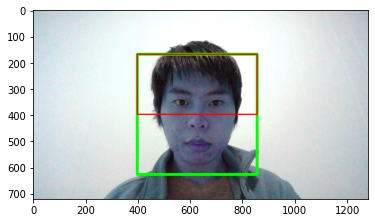

398 168


In [63]:

#Determine label using the first frame
labelInfo = ""
labelHalfInfo = ""
for fileName in frameFileNames:
  image = cv2.imread("./data/obj/frame" + fileName + ".jpg")
  if(image is None): #if failed to read
    continue #skip to next
  
  imageCVCoor = getFaceCoordinates(image)
  if(imageCVCoor is None): #if didn't detect face on first image
    continue #skip to next image

  imageCVCoor = expandLabelArea(imageCVCoor) #expand the label area
  imageCVCoorHalf = topHalfLabelCVCoor(imageCVCoor) #get the top half of the expanded
  
  # 2 - full face, 3 - top half of face. 0 & 1 are reserved for mask & no mask respectively
  labelInfo = YOLOCoorGen(2, imageCVCoor, image.shape)
  labelInfoHalf = YOLOCoorGen(3, imageCVCoorHalf, image.shape)

  #print finalized coor
  print(labelInfo)
  print(labelInfoHalf)

  #Display image + bound box:
  x, y, w, h = (imageCVCoor[0], imageCVCoor[1], imageCVCoor[2], imageCVCoor[3])
  x2, y2, w2, h2 = (imageCVCoorHalf[0], imageCVCoorHalf[1], imageCVCoorHalf[2], imageCVCoorHalf[3])
  cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 10)
  cv2.rectangle(image, (x2, y2), (x2+w2, y2+h2), (255, 0, 0), 3)

  plt.imshow(image)
  plt.show()
  print(f"{x} {y}")

  #437 207

  break
  #0 0.520312 0.605556 0.357812 0.636111
  cv2.destroyAllWindows()
  

In [65]:
#create labels
for fileName in frameFileNames:
  labelName = "./data/obj/frame" + fileName + ".txt"
  print('Creating...' + labelName)

  writeLabel(labelName, labelInfo, labelInfoHalf)

Creating..../data/obj/frame0.txt
Creating..../data/obj/frame1.txt
Creating..../data/obj/frame2.txt
Creating..../data/obj/frame3.txt
Creating..../data/obj/frame4.txt
Creating..../data/obj/frame5.txt
Creating..../data/obj/frame6.txt
Creating..../data/obj/frame7.txt
Creating..../data/obj/frame8.txt
Creating..../data/obj/frame9.txt
Creating..../data/obj/frame10.txt
Creating..../data/obj/frame11.txt
Creating..../data/obj/frame12.txt
Creating..../data/obj/frame13.txt
Creating..../data/obj/frame14.txt
Creating..../data/obj/frame15.txt
Creating..../data/obj/frame16.txt
Creating..../data/obj/frame17.txt
Creating..../data/obj/frame18.txt
Creating..../data/obj/frame19.txt
Creating..../data/obj/frame20.txt
Creating..../data/obj/frame21.txt
Creating..../data/obj/frame22.txt
Creating..../data/obj/frame23.txt
Creating..../data/obj/frame24.txt
Creating..../data/obj/frame25.txt
Creating..../data/obj/frame26.txt
Creating..../data/obj/frame27.txt
Creating..../data/obj/frame28.txt
Creating..../data/obj/fr

In [ ]:
''' 
#Checks for a face for every frame via opencv cascade (don't use b/c large # of false positives if head is turned)
#create labels
labelInfo = ""
labelHalfInfo = ""

for fileName in frameFileNames:
  labelName = "./data/obj/frame" + fileName + ".txt"
  #print('Creating...' + labelName)

  image = cv2.imread("./data/obj/frame" + fileName + ".jpg")
  if(image is None): #if failed to read
    writeLabel(labelName, labelInfo, labelInfoHalf) #write with previous info
    continue #skip to next
  
  imageCVCoor = getFaceCoordinates(image)
  if(imageCVCoor is None): #if didn't detect face on first image
    writeLabel(labelName, labelInfo, labelInfoHalf) #write with previous info
    continue #skip to next image

  imageCVCoor = expandLabelArea(imageCVCoor) #expand the label area
  imageCVCoorHalf = topHalfLabelCVCoor(imageCVCoor) #get the top half of the expanded
  
  #update labels
  labelInfo = YOLOCoorGen(0, imageCVCoor, image.shape)
  labelInfoHalf = YOLOCoorGen(1, imageCVCoorHalf, image.shape)

  #print finalized coor
  #print(labelInfo)
  #print(labelInfoHalf)

  if(frameFileNames == "124"): #test
    x, y, w, h = (imageCVCoor[0], imageCVCoor[1], imageCVCoor[2], imageCVCoor[3])
    x2, y2, w2, h2 = (imageCVCoorHalf[0], imageCVCoorHalf[1], imageCVCoorHalf[2], imageCVCoorHalf[3])
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 10)
    cv2.rectangle(image, (x2, y2), (x2+w2, y2+h2), (255, 0, 0), 3)
    plt.imshow(image)
    plt.show()

  writeLabel(labelName, labelInfo, labelInfoHalf)
  cv2.destroyAllWindows()
  '''

### Extract Mask Data

In [66]:
!unzip /content/drive/MyDrive/yolov3/masks.zip -d data/obj

Archive:  /content/drive/MyDrive/yolov3/masks.zip
  inflating: data/obj/0_10725_jpg.rf.99ff78c82dadd6d49408164489cb6582.jpg  
  inflating: data/obj/0_10725_jpg.rf.99ff78c82dadd6d49408164489cb6582.txt  
  inflating: data/obj/0_8w7mkX-PHcfMM5s6_jpeg.rf.74932d662e4077ea5e4374a0038e5757.jpg  
  inflating: data/obj/0_8w7mkX-PHcfMM5s6_jpeg.rf.74932d662e4077ea5e4374a0038e5757.txt  
  inflating: data/obj/000_1ov3n5_0_jpeg.rf.a23f1c89491779996f4519858277a4e0.jpg  
  inflating: data/obj/000_1ov3n5_0_jpeg.rf.a23f1c89491779996f4519858277a4e0.txt  
  inflating: data/obj/0002526673_jpg.rf.2c547115c01c1b5a10c6d467551f0cae.jpg  
  inflating: data/obj/0002526673_jpg.rf.2c547115c01c1b5a10c6d467551f0cae.txt  
  inflating: data/obj/000b7b75-1600_jpg.rf.5d7117e8571505dbfe49e2f737089ea0.jpg  
  inflating: data/obj/000b7b75-1600_jpg.rf.5d7117e8571505dbfe49e2f737089ea0.txt  
  inflating: data/obj/001_1024_jpeg.rf.f915f4689737658b59732df33fdbee22.jpg  
  inflating: data/obj/001_1024_jpeg.rf.f915f4689737658b597

# Training

### Create train.txt

In [67]:
#Tell which images + path that yolo needs to be trained on
images_list = glob.glob("data/obj/*.jpg")
with open("data/train.txt", "w") as f:
    f.write("\n".join(images_list))

### Download Pre-trained weights

In [68]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-11-25 05:47:28--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  51.2MB/s    in 3.2s    

2021-11-25 05:47:32 (48.9 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



### Execute

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_training.cfg darknet53.conv.74 -dont_show

Streaming output truncated to the last 5000 lines.
 total_bbox = 57393, rewritten_bbox = 0.045302 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.517523), count: 3, class_loss = 1.429315, iou_loss = 0.872752, total_loss = 2.302067 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.445787), count: 10, class_loss = 4.922387, iou_loss = 3.689252, total_loss = 8.611639 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.422814), count: 7, class_loss = 3.603007, iou_loss = 4.808114, total_loss = 8.411120 
 total_bbox = 57413, rewritten_bbox = 0.045286 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.354852), count: 8, class_loss = 3.816422, iou_loss = 4.534761, total_loss = 8.351184 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.325000), count: 3, class_loss = 1.534381, iou_loss = 2.266653, total_loss = 3.801034 
v3 (mse

In [ ]:
#use this in the event colab kicks you out (free tier)
#!./darknet detector train data/obj.data cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3/yolov3_training_last.weights -dont_show